In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from skimage.util import random_noise
import csv 
import time

## Load Dataset and create Dataloaders

In [2]:
train_path = "Data/A3 files/train_data.csv"

with open(train_path,"r",encoding="ascii") as f:
    csv_reader = csv.reader(f)
    train_data = list(csv_reader)

def input_output_split(data):
    input_data = []
    output_data = []
    for i in range(len(data)):
        input_data.append(data[i][0])
        output_data.append(data[i][1])
    return input_data,output_data

train_input , train_output = input_output_split(train_data[1:])  

train_input = np.array(train_input)

In [3]:
eval_path = "Data/A3 files/eval_data.csv"

with open(eval_path,"r",encoding="ascii") as f:
    csv_reader = csv.reader(f)
    train_data = list(csv_reader)

eval_input , eval_output = input_output_split(train_data[1:])  

### Convert all charecters to indices and create a dictionary mapping each unique charecter to a unique index

In [4]:
charecters = set("abcdefghijklmnopqrstuvwxyz")

len_vocab = len(charecters)

char_to_int = dict((c,i) for i,c in enumerate(charecters))
char_to_int["@"] = 26               # SOS token
print(char_to_int)

int_to_char = dict((i,c) for i,c in enumerate(charecters))
int_to_char[26] = "@"               # SOS token
print(int_to_char)
# 
def encode_data(data):
    encoded_data = []
    for i in range(len(data)):                  # appending 0 for <SOS> token 
        encoded_data.append([char_to_int[char] for char in data[i]])
    
    # encoded_data = [[[0]]] + encoded_data         # appending 0 for <SOS> token
    return encoded_data

def decode_data(data):
    decoded_data = []
    for i in range(len(data)+1):
        if i == 0:
            continue

        decoded_data.append([int_to_char[int] for int in data[i]])
    return decoded_data

encoded_train_input = encode_data(train_input)          # encoded_train_input is a list of lists
encoded_train_output = encode_data(train_output)        # encoded_train_output is a list of lists

encoded_eval_input = encode_data(eval_input)          # encoded_eval_input is a list of lists
encoded_eval_output = encode_data(eval_output)        # encoded_eval_output is a list of lists

# for i in range(len(encoded_train_input)):
#     encoded_train_input[i] = [0] + encoded_train_input[i]

for i in range(len(encoded_train_output)):
    encoded_train_output[i] = [26] + encoded_train_output[i]

for i in range(len(encoded_train_input)):
    encoded_train_input[i] = [26] + encoded_train_input[i]

for i in range(len(encoded_eval_input)):
    encoded_eval_input[i] = [26] + encoded_eval_input[i]

for i in range(len(encoded_eval_output)):
    encoded_eval_output[i] = [26] + encoded_eval_output[i]


def one_hot_encode(data):
    encoded_data = []
    for i in range(len(data)):                  # For every data point
        encoded_data.append(np.zeros((9,27)))      # Create a 9x27 matrix of zeros
        for j in range(len(data[i])):
            encoded_data[i][j][data[i][j]] = 1
    return encoded_data

one_hot_encoded_target = one_hot_encode(encoded_train_output)
one_hot_encoded_eval_target = one_hot_encode(encoded_eval_output)


{'u': 0, 'c': 1, 'd': 2, 'v': 3, 'y': 4, 'g': 5, 's': 6, 'r': 7, 'w': 8, 't': 9, 'l': 10, 'e': 11, 'a': 12, 'h': 13, 'x': 14, 'k': 15, 'q': 16, 'n': 17, 'j': 18, 'i': 19, 'f': 20, 'm': 21, 'z': 22, 'o': 23, 'b': 24, 'p': 25, '@': 26}
{0: 'u', 1: 'c', 2: 'd', 3: 'v', 4: 'y', 5: 'g', 6: 's', 7: 'r', 8: 'w', 9: 't', 10: 'l', 11: 'e', 12: 'a', 13: 'h', 14: 'x', 15: 'k', 16: 'q', 17: 'n', 18: 'j', 19: 'i', 20: 'f', 21: 'm', 22: 'z', 23: 'o', 24: 'b', 25: 'p', 26: '@'}


### Checking Shapes

In [5]:
train_source = torch.tensor(encoded_train_input)
train_target = torch.tensor(encoded_train_output)
# train_target_one_hot = torch.tensor(one_hot_encoded_target)

eval_source = torch.tensor(encoded_eval_input)
eval_target = torch.tensor(encoded_eval_output)
# eval_target_one_hot = torch.tensor(one_hot_encoded_eval_target)

print(train_source.shape)
print(train_target.shape)
# print(train_target_one_hot.shape)

print(eval_source.shape)
print(eval_target.shape)
# print(eval_target_one_hot.shape)


torch.Size([7000, 9])
torch.Size([7000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])


### Positional Embedding as Per Transformer Paper
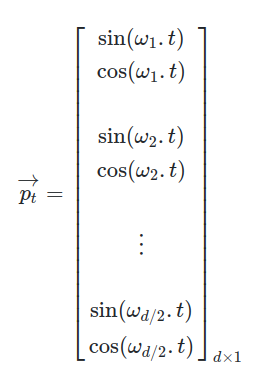
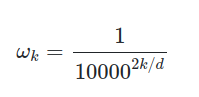

In [6]:
def positional_encoding(seq_len, emb_dim):
    pos = torch.arange(seq_len, dtype=torch.float).reshape(1, seq_len, 1)
    dim = torch.arange(emb_dim, dtype=torch.float).reshape(1, 1, emb_dim)
    phase = pos / torch.pow(10000, 2 * (dim // 2) / emb_dim)
    phase[:, :, 0::2] = torch.sin(phase[:, :, 0::2])
    phase[:, :, 1::2] = torch.cos(phase[:, :, 1::2])
    return phase

phase = positional_encoding(9,128)

print(phase.shape)


torch.Size([1, 9, 128])


In [7]:
# Make Dataset and DataLoader
class MyDataset(Dataset):
    def __init__(self, source, target):
        self.source = source
        self.target = target

    def __getitem__(self, index):
        return self.source[index], self.target[index]

    def __len__(self):
        return len(self.source)
    
train_dataset = MyDataset(train_source, train_target)
eval_dataset = MyDataset(eval_source, eval_target)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=128, shuffle=True)

### Create Transformer Class

In [8]:
### Transformer Model
class Transformer(nn.Module):
    def __init__(self,emb_dim,heads,depth,seq_length,num_tokens,num_classes,dropout):
        super().__init__()
        self.num_tokens = num_tokens
        self.token_emb = nn.Embedding(num_tokens,emb_dim)
        self.tgt_emb = nn.Embedding(num_tokens,emb_dim)
        self.pos_emb = nn.Embedding(seq_length,emb_dim)                 # positional encoding
        self.emb_dim = emb_dim
        self.seq_length = seq_length
        self.transformer = nn.Transformer(d_model=emb_dim,nhead=heads,num_encoder_layers=depth,num_decoder_layers=depth,dropout=dropout,batch_first=True)
        self.fc = nn.Linear(emb_dim,num_classes)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self,src,tgt):
        # tgt = tgt [:,:-1]            # Remove the Last token of Target, seq is now of lenghth 8
        # print(tgt.shape)
        
        src_tokens = self.token_emb(src)
        tgt_tokens = self.tgt_emb(tgt)

        b,t,e = src_tokens.size()
        # positions = self.pos_emb(torch.arange(t))[None,:,:].expand(b,t,e)
        # x = tokens + positions
        src_tokens = src_tokens + phase
        src_tokens = self.dropout(src_tokens)

        tgt_tokens = tgt_tokens + phase[:,:tgt.shape[1]]
        tgt_tokens = self.dropout(tgt_tokens)

        
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt.shape[1])
        x = self.transformer(src_tokens,tgt_tokens,tgt_mask=tgt_mask)
        x = self.fc(x)
        return x
    
    def predict(self,x):            # currently not batched ( Will do later)
        ### x : str
        ### x = "abcd"

        # convert src to tensor
        src = encode_data(x)
        src = [[26]] + src

        src = torch.tensor(src)         # Src is now a tensor of shape (seq_length,1)
        # Covert to [1,9] or [batch_size,seq_length]
        src = src.reshape(1,src.shape[0])
        # print(src.shape)

        tgt = torch.tensor([[26]])          # Only SOS
        # print(tgt.shape)

        for i in range(8):          # 8 timess to get 8 tokens in the output
            # Append Garbage value to tgt
            # print("Target shape Before",tgt.shape)
            # tgt = torch.cat((tgt,torch.tensor([[26]])),dim=1)
            logits = self.forward(src,tgt)              # logits = [batch_size,seq_length,27]
            # Apply softmax to get indices
            # print("Logits shape",logits.shape)
            
            logits = logits.argmax(dim=2)              # logits = [batch_size,seq_length]

            # print("Logits :",logits)

            # print(logits[:,-1].reshape(1,-1))
            ## Append this to tgt
            tgt = torch.cat((tgt,logits[:,-1].reshape(1,-1)),dim=1)
            # print("Target shape After",tgt.shape)
        
        # print(tgt.shape)      # [1,9]
        # Convert tgt to string
        final = ""
        
        for i in range(1,9):
            # print(tgt[0][i])
            final += int_to_char[int(tgt[0][i])]

        return final
        
            



In [9]:
### Hyperparamaters
num_epochs = 50
learning_rate = 0.0005
emb_dim = 128
heads = 8
depth = 2
seq_length = 9
num_tokens = 27
num_classes = 27
dropout = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Transformer(emb_dim,heads,depth,seq_length,num_tokens,num_classes,dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

def train(model,train_loader,optimizer,criterion):  # Batch first
    model.train()
    losses = []
    for source,target in train_loader:
        source = source.to(device)
        target = target.to(device)
        output = model(source,target[:,:-1])        # Removing last token from target
        output = output.permute(0,2,1)              # output = [batch_size,seq_length,num_classes]  -> [batch_size,num_classes,seq_length]
        loss = criterion(output,target[:,1:])           # Removing SOS token
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return np.mean(losses)

def evaluate(model,eval_loader,criterion):
    model.eval()
    losses = []
    for source,target in eval_loader:
        source = source.to(device)
        target = target.to(device)
        output = model(source,target[:,:-1])
        output = output.permute(0,2,1)
        loss = criterion(output,target[:,1:])
        losses.append(loss.item())
    return np.mean(losses)

def epoch_time(start_time,end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time/60)
    elapsed_secs = int(elapsed_time-(elapsed_mins*60))
    return elapsed_mins,elapsed_secs


### Training Loop

In [10]:
best_valid_loss = float('inf')
for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = train(model,train_loader,optimizer,criterion)
    valid_loss = evaluate(model,eval_loader,criterion)
    end_time = time.time()
    epoch_mins,epoch_secs = epoch_time(start_time,end_time)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(),"transformer_model.pt")
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(),"transformer_model.pt")

Epoch: 01 | Time: 0m 7s
	Train Loss: 3.286
	 Val. Loss: 3.263
Epoch: 02 | Time: 0m 6s
	Train Loss: 3.267
	 Val. Loss: 3.255
Epoch: 03 | Time: 0m 6s
	Train Loss: 3.253
	 Val. Loss: 3.237
Epoch: 04 | Time: 0m 6s
	Train Loss: 3.189
	 Val. Loss: 3.022
Epoch: 05 | Time: 0m 6s
	Train Loss: 3.001
	 Val. Loss: 2.862
Epoch: 06 | Time: 0m 6s
	Train Loss: 2.754
	 Val. Loss: 2.637
Epoch: 07 | Time: 0m 6s
	Train Loss: 2.665
	 Val. Loss: 2.632
Epoch: 08 | Time: 0m 6s
	Train Loss: 2.650
	 Val. Loss: 2.627
Epoch: 09 | Time: 0m 6s
	Train Loss: 2.648
	 Val. Loss: 2.628
Epoch: 10 | Time: 0m 6s
	Train Loss: 2.642
	 Val. Loss: 2.628
Epoch: 11 | Time: 0m 6s
	Train Loss: 2.635
	 Val. Loss: 2.629
Epoch: 12 | Time: 0m 6s
	Train Loss: 2.630
	 Val. Loss: 2.623
Epoch: 13 | Time: 0m 6s
	Train Loss: 2.628
	 Val. Loss: 2.632
Epoch: 14 | Time: 0m 6s
	Train Loss: 2.625
	 Val. Loss: 2.627
Epoch: 15 | Time: 0m 6s
	Train Loss: 2.626
	 Val. Loss: 2.629
Epoch: 16 | Time: 0m 6s
	Train Loss: 2.621
	 Val. Loss: 2.627
Epoch: 1

### Testing out for one sentence

In [11]:
# print(train_loader.dataset[0][0].unsqueeze(0))

input  = ""
for p in train_loader.dataset[0][0]:
    input += int_to_char[p.item()]

input = input[1:]

print("Input :",input)
# print(model.predict(train_loader.dataset[0][0].unsqueeze(0)))
prediction = model.predict("udaxihhe")
# print(prediction)
# prediction = prediction.squeeze(0)

# pred = ""
# for p in prediction:
#     pred += int_to_char[p.item()]

print("Prediction ",prediction)

output = ""
for p in train_loader.dataset[0][1]:
    output += int_to_char[p.item()]

output = output[1:]

print("Output :",output)

Input : udaxihhe
Prediction  fmvmfthn
Output : fmvmfthn


### Checking all Evaluation predictions

In [13]:
eval_preds = []
for b in eval_input:
    eval_preds.append(model.predict(b))

def check(pred,true):
    correct = {}
    for i in range(9):
        correct[i] = 0
    
    char_corr = 0
    for a, b in zip(pred, true):
        char_corr = 0
        for i in range(8):
            if a[i] == b[i]:
                char_corr += 1
        
        correct[char_corr] += 1
    return correct

eval_targets = eval_output

eval_dict = check(eval_preds,eval_targets)

for i in range(9):
    print(f"Number of Strings with {i} Correct characters is {eval_dict[i]}")

Number of Strings with 0 Correct characters is 0
Number of Strings with 1 Correct characters is 0
Number of Strings with 2 Correct characters is 0
Number of Strings with 3 Correct characters is 0
Number of Strings with 4 Correct characters is 0
Number of Strings with 5 Correct characters is 0
Number of Strings with 6 Correct characters is 0
Number of Strings with 7 Correct characters is 0
Number of Strings with 8 Correct characters is 2000


### Checking all Train predictions

In [14]:

train_preds = []
for a in train_input:
    train_preds.append(model.predict(a))


targets = train_output

# print(targets[0].shape)

dict = check(train_preds,targets)

for i in range(9):
    print(f"Number of Strings with {i} Correct characters is {dict[i]}")


Number of Strings with 0 Correct characters is 0
Number of Strings with 1 Correct characters is 0
Number of Strings with 2 Correct characters is 0
Number of Strings with 3 Correct characters is 0
Number of Strings with 4 Correct characters is 0
Number of Strings with 5 Correct characters is 0
Number of Strings with 6 Correct characters is 0
Number of Strings with 7 Correct characters is 0
Number of Strings with 8 Correct characters is 7000
